# Fitting sinusoidal oscillation 

In [17]:
import numpy as np 
import os 
import datetime
import celerite
from celerite import terms
import numpy as np
import matplotlib.pyplot as plt
from celerite import terms
from scipy.optimize import minimize
from matplotlib import rcParams   
%config IPython.matplotlib.backend = "retina"
from itertools import product
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 100
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

## Tests <a id='toc'></a>
   * [1: freezing log_c parameter](#freeze)
   * [2: recovering varying amplitudes](#amplitudes)
   * [3: failing cases](#fail)

In [56]:
def fit_sinusoid(t,y,yerr, A = 1, period = 100, plot=True,freeze_c=False, 
                verbose  = True ):
    ''' 
    A function to fit the provided time series using Celerite 
    with pre-defined kernels.  
        
    kernel = 'sinusoidal' corresponds to the kernel appropriate for 
        y = A * sin(omega * t) , i.e. Celerite 'ComplexTerm'
        with b = 0, corresponding to eq.(10) in Foreman-Mackey+2017.
        Note that the sinusoidal kernel includes the exponential : 
        k(tau) = a_j * exp(- c_j * tau ) * cos(d_j * tau)
        
    A, period are the true values of parameters, used to 
        set the initial kernel 
    '''
    omega = 2*np.pi / period 
    if verbose : 
        print('A_in=', A,  'omega_in=', omega)
    
    if verbose:
        print('Using sinusoidal kernel')
    k = terms.ComplexTerm(log_a = np.log(A/2) ,log_c = -10,
                          log_d = np.log(omega))
    if freeze_c : 
        k.freeze_parameter("log_c") 

                    
    # define the GP kernel 
    gp = celerite.GP(k,mean=np.mean(y))
    gp.compute(t,yerr)

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

    r = minimize(neg_log_like, initial_params, 
             method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    #print(r)
    res = gp.get_parameter_dict()
    
    # sinusoidal kernel 
    A_fit = np.sqrt(2 * np.exp(res['kernel:log_a']))
    omega_fit = np.exp(res['kernel:log_d'])
    if not freeze_c : 
        c_fit = np.exp(res['kernel:log_c'])
        if verbose: 
            print('A_fit=',A_fit,  'omega_fit=',omega_fit, 
              'real part of the exponent, c=',  c_fit )
        results = {'A_fit':A_fit, 'omega_fit':omega_fit, 'c_fit':c_fit}
    elif freeze_c:
        if verbose:
            print('A_fit=',A_fit,  'omega_fit=',omega_fit)
        results = {'A_fit':A_fit, 'omega_fit':omega_fit}


    # plot the prediction 
    if plot is True:
        x = np.linspace(0, max(t), 5000)
        pred_mean, pred_var = gp.predict(y, x, return_var=True)
        pred_std = np.sqrt(pred_var)

        color = "#ff7f0e"
        fig,ax = plt.subplots(1,1,figsize=(8,6))
        ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
        ax.plot(x, pred_mean, color=color)
        ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, 
                         color=color, alpha=0.3,
                         edgecolor="none")
        ax.set_title('A = '+str(A)[:5])
        ax.set_xlabel('time')
        ax.set_ylabel('mag')
        plt.show()
        plt.close(fig)
        
    return results

### Test 1 :  freezing log_c  parameter worsens the fit  <a id='freeze'></a>

For a function $y = A \sin{(\omega t)}$, the covariance ($k(\tau) = $) is $k(\tau) = \frac{A}{2} \cos{(\omega \tau)}$.

This is matched by Celerite kernel 

$ k(\tau) = \frac{1}{2}\,\left[(a_j + b_j)\,e^{-(c_j+d_j)\,\tau}
     + (a_j - b_j)\,e^{-(c_j-d_j)\,\tau}\right]
$

which with $b_{j} = 0$ (as in [Foreman-Mackey+2017](https://doi.org/10.3847/1538-3881/aa9332), eq. 10), becomes 

$ k(\tau) = a_{j} e^{-(c_j \,\tau)}  \cos{(d_j)\,\tau)}$, 

if $a_{j} \equiv A/2$ , $c_{j} = 0$, $d_{j} = \omega$. 



In [19]:
# Simulated time series 
%matplotlib inline
period = 200
A = 1
omega = 2*np.pi / period

np.random.seed(41)  # The input coordinates must be sorted
# two samples a day - very dense 
t = np.sort(np.random.uniform(0, 1000, 2000))  

# the photometric errors drawn from uniform distribution
# between lower and upper noise value 
# those correspond to very low noise 
yerr = np.random.uniform(0.01, 0.02, len(t))
noise = yerr * np.random.randn(len(t)) 
mean = 15 

# define the ideal underlying signal
y_sin =  A*np.sin(omega*t) + mean

# add Gaussian noise to create observed data
y_obs = y_sin+noise


Fit with free parameter log_c : 

A_in= 4.155845845845846 omega_in= 0.031415926535897934
Using sinusoidal kernel
A_fit= 4.15901142929 omega_fit= 0.0314138839336 real part of the exponent, c= 1.13641752468e-06


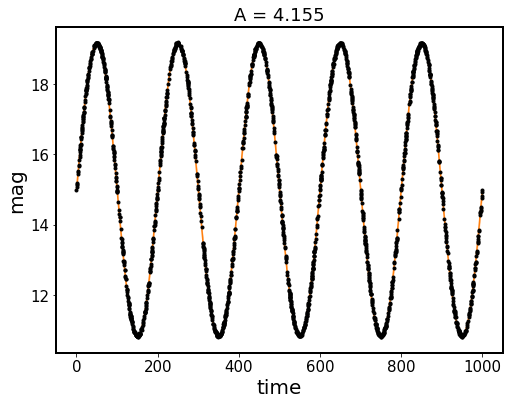

In [57]:
results = fit_sinusoid(t,y_obs,yerr, A, period , plot=True,freeze_c=False)

Fit without free parameter log_c : 

A_in= 4.155845845845846 omega_in= 0.031415926535897934
Using sinusoidal kernel
A_fit= 0.785549358463 omega_fit= 0.0314131289988


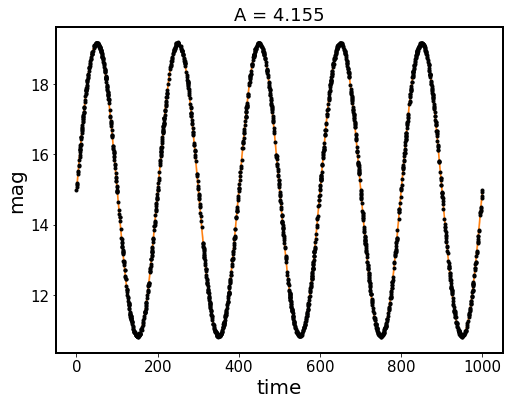

In [58]:
results = fit_sinusoid(t,y_obs,yerr, A , period,  plot=True,freeze_c=True)

Why freezing log_c parameter makes the recovered Amplitude and angular frequency $\omega$ worse?

### Test 2 : vary amplitude, with free log_c parameter <a id='amplitudes'></a>
[move to top](#toc)

A_in= 0.01 omega_in= 0.031415926535897934
Using sinusoidal kernel
A_fit= 0.00997522800384 omega_fit= 0.0318671518607 real part of the exponent, c= 7.64119133921e-07


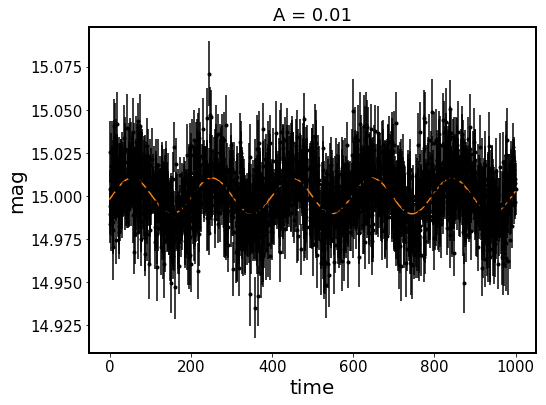

A_in= 0.342222222222 omega_in= 0.031415926535897934
Using sinusoidal kernel
A_fit= 0.342719406633 omega_fit= 0.0314356068027 real part of the exponent, c= 4.75213938107e-06


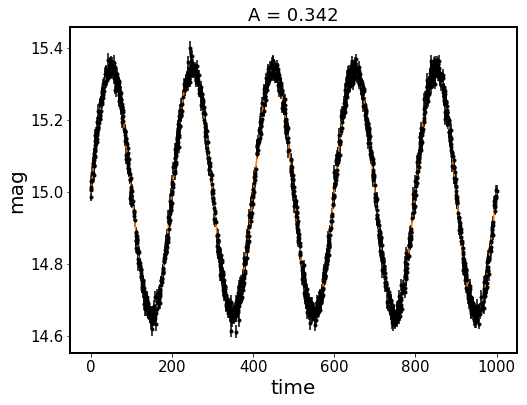

A_in= 0.674444444444 omega_in= 0.031415926535897934
Using sinusoidal kernel


LinAlgError: failed to factorize or solve matrix

In [59]:
# Using the same omega as before : P =200 
for A in np.linspace(0.01,3,10)  : 
    
    # define the ideal underlying signal
    y_sin =  A*np.sin(omega*t) + mean

    # add Gaussian noise to create observed data
    y_obs = y_sin+noise
    
    # compute Celerite fit 
    results = fit_sinusoid(t,y_obs,yerr, A, period , plot=True,freeze_c=False)
    

I see from above examples that for $A \sim 1$ , we are able to retrieve the input amplitude, but not otherwise. 

Investigate that over the range of input amplitudes. Plot input vs output. 

In [60]:
A_in = []  ;  A_fit = []
# Using the same omega as before : P =200
A_values = np.linspace(0.01, 5, 1000)
i = 0 
for A in  A_values : 
    print(i, A)
    # define the ideal underlying signal
    y_sin =  A*np.sin(omega*t) + mean

    # add Gaussian noise to create observed data
    y_obs = y_sin+noise
    
    # compute Celerite fit 
    results = fit_sinusoid(t,y_obs,yerr, A, period , plot=False,freeze_c=False, 
                          verbose = False )
    
    # store the results 
    A_in.append(A)
    A_fit.append(results['A_fit'])
    i += 1 

0 0.01
1 0.014994994995
2 0.01998998999
3 0.024984984985
4 0.02997997998
5 0.034974974975
6 0.03996996997
7 0.044964964965
8 0.04995995996
9 0.054954954955
10 0.0599499499499
11 0.0649449449449
12 0.0699399399399
13 0.0749349349349
14 0.0799299299299
15 0.0849249249249
16 0.0899199199199
17 0.0949149149149
18 0.0999099099099
19 0.104904904905
20 0.1098998999
21 0.114894894895
22 0.11988988989
23 0.124884884885
24 0.12987987988
25 0.134874874875
26 0.13986986987
27 0.144864864865
28 0.14985985986
29 0.154854854855
30 0.15984984985
31 0.164844844845
32 0.16983983984
33 0.174834834835
34 0.17982982983
35 0.184824824825
36 0.18981981982
37 0.194814814815
38 0.19980980981
39 0.204804804805
40 0.2097997998
41 0.214794794795
42 0.21978978979
43 0.224784784785
44 0.22977977978
45 0.234774774775
46 0.23976976977
47 0.244764764765
48 0.24975975976
49 0.254754754755
50 0.25974974975
51 0.264744744745
52 0.26973973974
53 0.274734734735
54 0.27972972973
55 0.284724724725
56 0.28971971972
57 0.29471

LinAlgError: failed to factorize or solve matrix

In [61]:
A_values[133]

0.67433433433433443

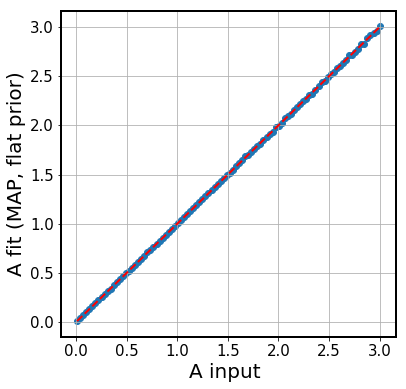

In [28]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(A_in, A_fit)
ax.set_xlabel('A input ')
ax.set_ylabel('A fit (MAP, flat prior)')
x = np.linspace(min(A_in), max(A_in))
ax.plot(x,x, ls = '--', lw=2 ,c= 'red')
ax.grid()
#ax.set_xlim(0,9)
#ax.set_ylim(0,9)

The question : why can't we correctly retrieve the input amplitude , even for A >> noise ? 

### Test 3 : Failure cases <a id='fail'></a>

[move to top](#toc)

In [62]:
#Failure 
A = 0.67433433433433443
y_sin =  A*np.sin(omega*t) + mean

# add Gaussian noise to create observed data
y_obs = y_sin+noise

# compute Celerite fit 
results = fit_sinusoid(t,y_obs,yerr, A, period , plot=True,freeze_c=False, 
                      verbose = False )

LinAlgError: failed to factorize or solve matrix

If I only remove the last digit of amplitude, it works! 

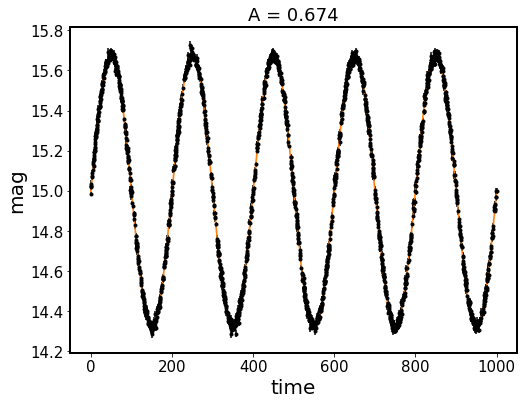

In [64]:
# Works  
A = 0.674334334334334
y_sin =  A*np.sin(omega*t) + mean

# add Gaussian noise to create observed data
y_obs = y_sin+noise

# compute Celerite fit 
results = fit_sinusoid(t,y_obs,yerr, A, period , plot=True,freeze_c=False, 
                      verbose = False )